In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from tqdm import tqdm
import functools

## Data

In [2]:
data = pd.read_csv('Quant_Invest_Fundusze.csv', sep = ';')
data['Daty'] = pd.to_datetime(data['Daty'])
data = data.set_index('Daty')

In [37]:
data = data.sort_index()

## Simple Models

In [34]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.risk_models import CovarianceShrinkage

In [170]:
fun_list = ['max_sharpe()','min_volatility()',
            'efficient_risk(0.01)','efficient_risk(0.02)','efficient_risk(0.03)','efficient_risk(0.04)',
            'efficient_risk(0.05)','efficient_risk(0.8)','efficient_risk(0.1)',
            'efficient_return(0.01)','efficient_return(0.02)','efficient_return(0.03)','efficient_return(0.04)',
            'efficient_return(0.05)','efficient_return(0.6)','efficient_return(0.7)','efficient_return(0.8)',]

In [173]:
allModels = {}
allReturns = {}
for model in tqdm(fun_list):
    results = []
    returns = []
    for i in range(2012,2017):
        sample = data[data.index <= pd.to_datetime(str(i)+'-12-31')]
        sample2 = data[data.index <= pd.to_datetime(str(i+1)+'-12-31')]
        mu = expected_returns.mean_historical_return(sample)
        S = CovarianceShrinkage(sample).ledoit_wolf()
        ef = EfficientFrontier(mu, S)
        weights = eval('ef.'+model)
        weight_list = list(weights.values())
        weights['year'] = i
        results.append(pd.DataFrame(data = weights,index=[0]))
        change = list(((sample2.iloc[-1] - sample.iloc[-1])/sample.iloc[-1]))
        returns.append(1+sum(np.prod(np.array([change,weight_list]), axis = 0)))
        
        


    results_df = round(pd.concat(results),3)
    allReturns[model] = returns
    allModels[model] = results_df.set_index('year')
    


100%|██████████| 17/17 [00:11<00:00,  1.25it/s]


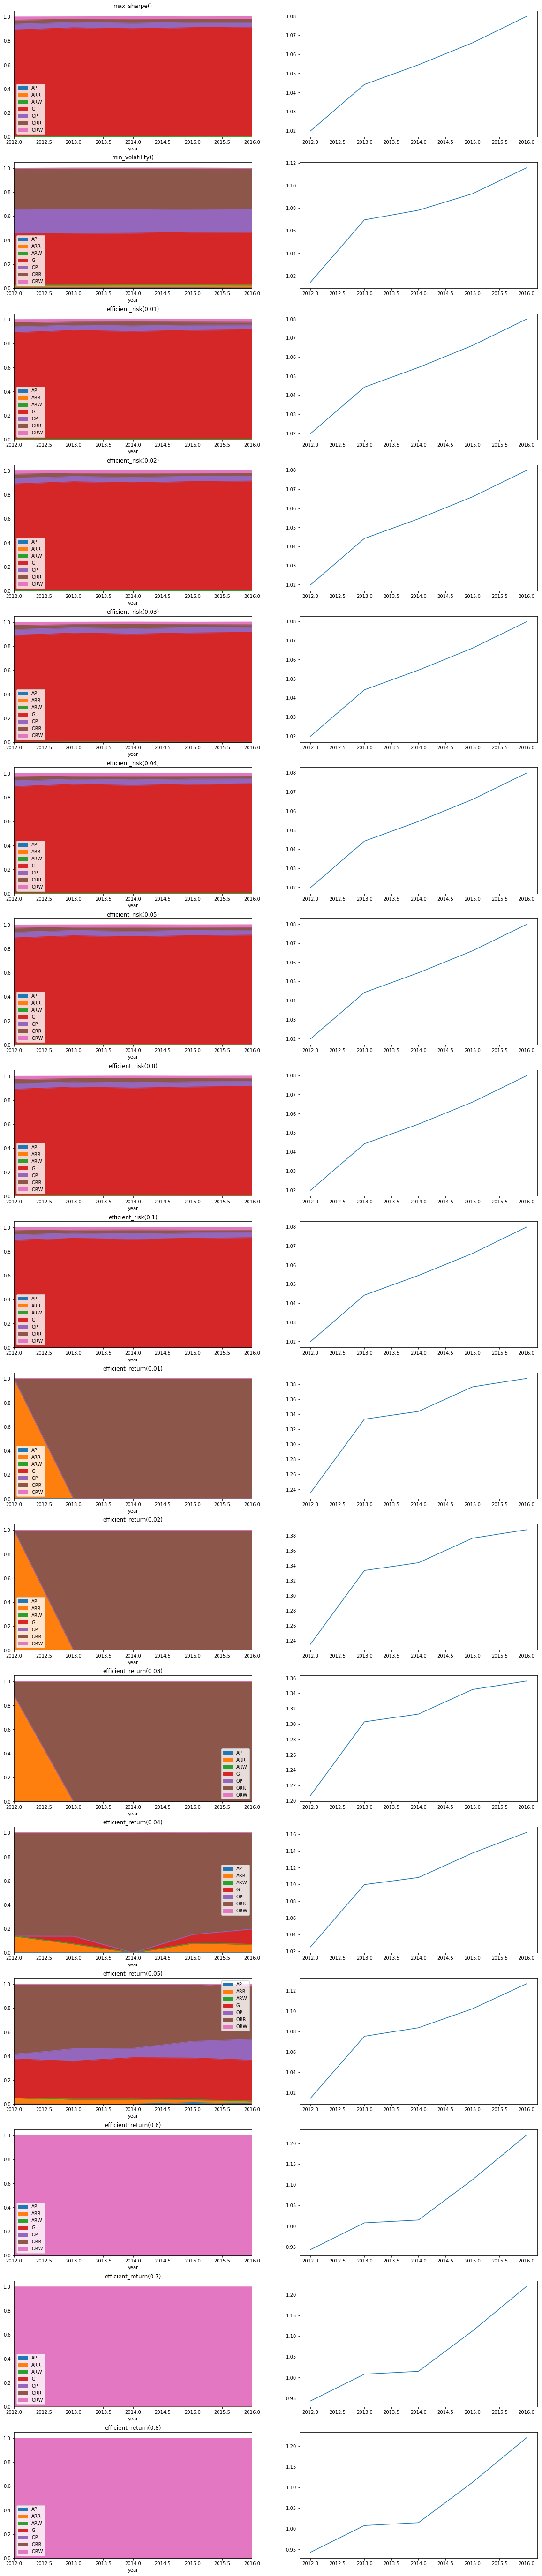

In [174]:
fig, ax = plt.subplots(nrows = 17, ncols = 2)
for i, title in enumerate(fun_list):
    allModels[title].plot(kind='area', stacked=True, title = title, ax = ax[i, 0])
    cumul= [1]
    for j in allReturns[title]:
        cumul.append(cumul[-1]*j)
    sns.lineplot(x = range(2012,2017),y = cumul[1:], ax = ax[i,1])
fig.set_size_inches(20, 100)

## Advanced Models

In [126]:
advanced = pd.read_csv('Results.txt', index_col = 0)

In [164]:
advanced_results = {}
model_names = advanced['model'].unique()
for model in model_names:
    advanced_results[model] = advanced[advanced['model']==model].drop('model', axis = 1)
    advanced_results[model] = advanced_results[model][advanced_results[model].index >=2012]
    advanced_results[model] = advanced_results[model][advanced_results[model].index <2018]
    totalReturn = [1]
    for i in advanced_results[model]['returns']:
        totalReturn.append(totalReturn[-1] * (1+i))
    advanced_results[model]['total_return'] = totalReturn[1:]

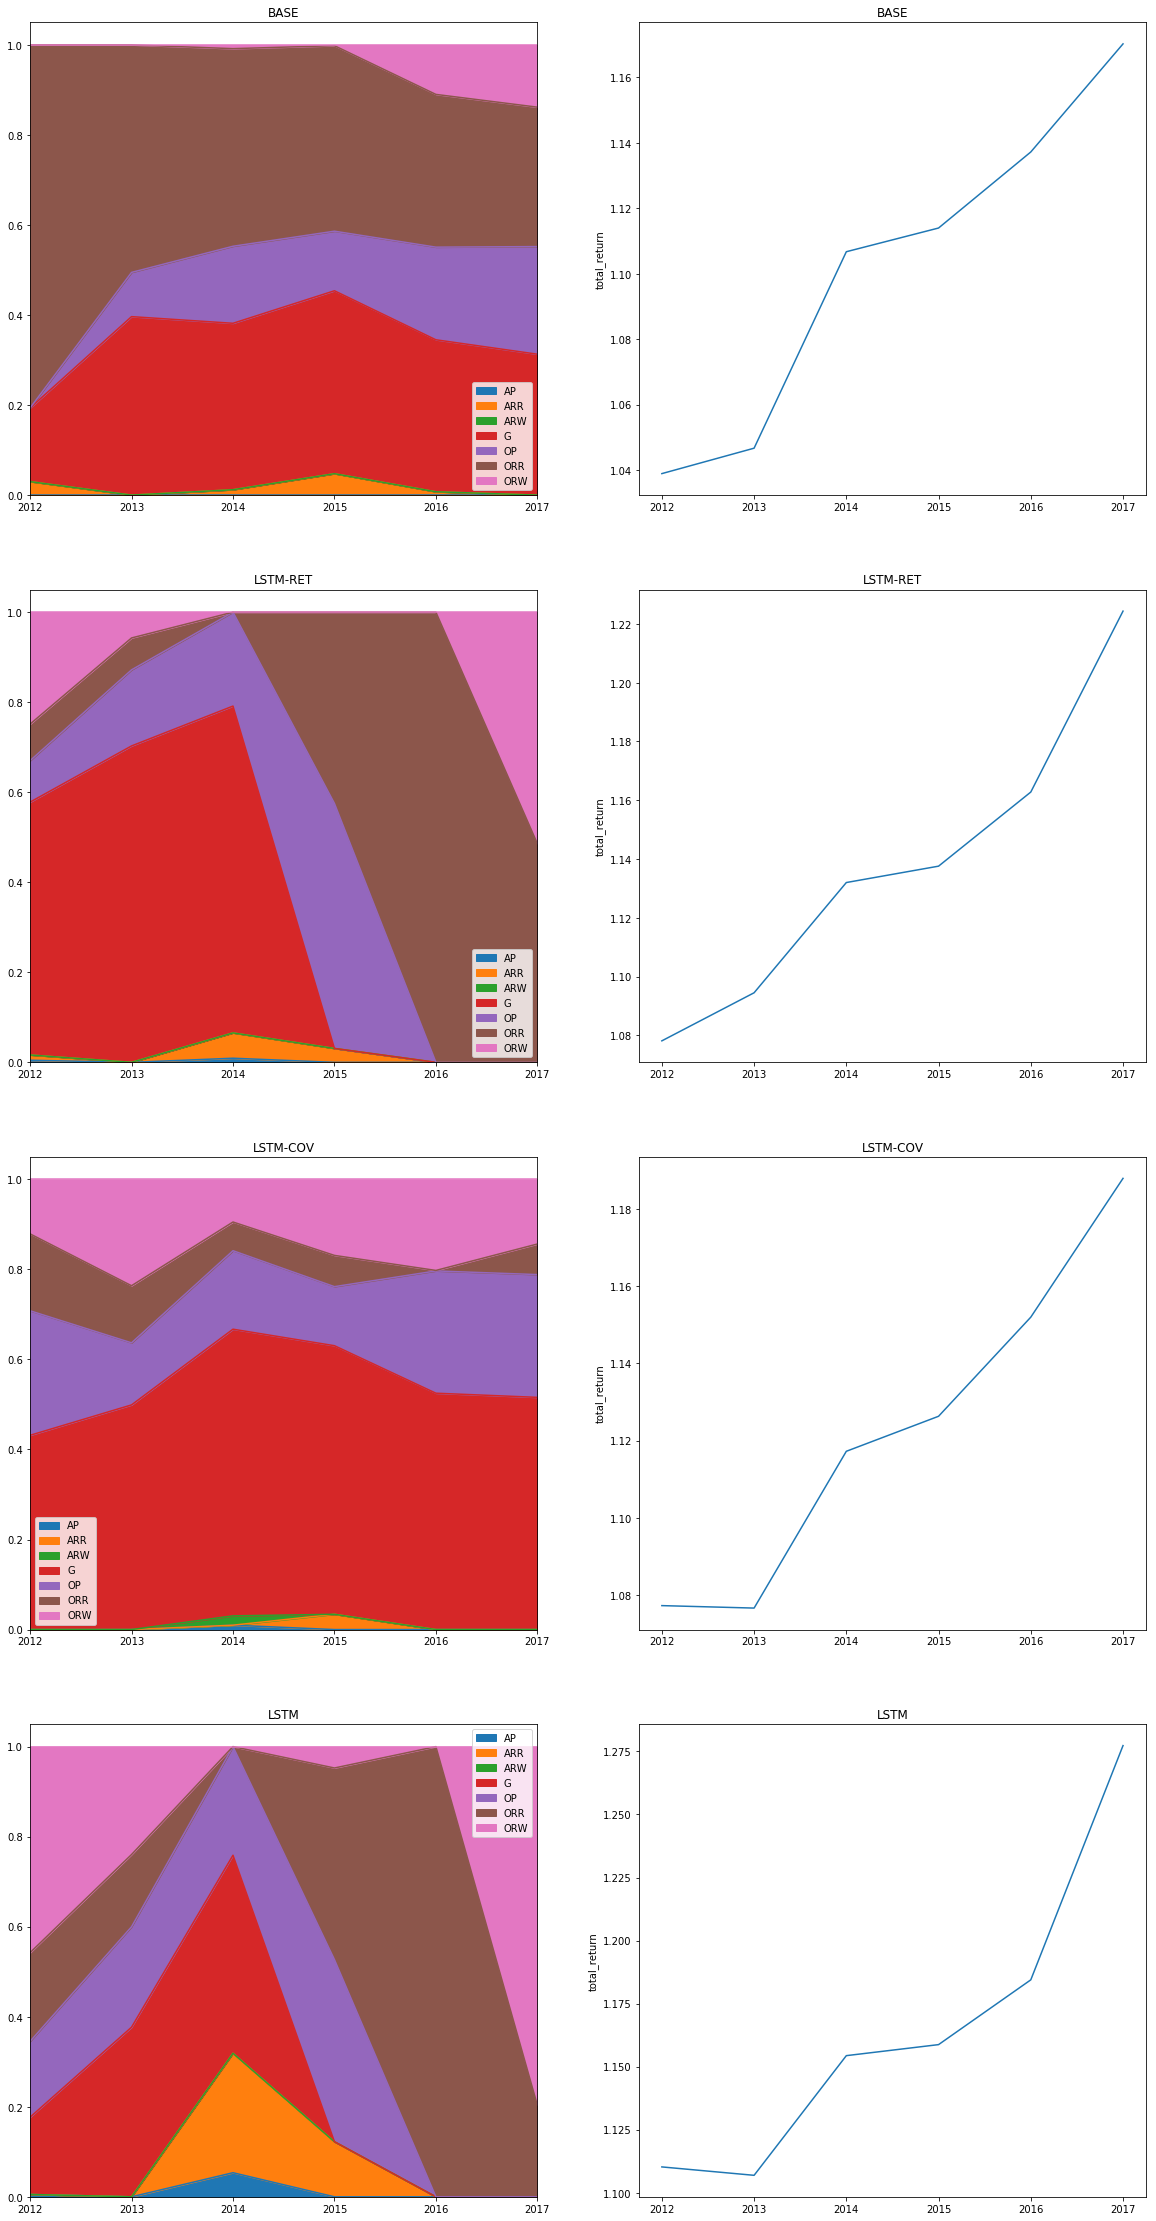

In [165]:
fig, ax = plt.subplots(nrows = 4, ncols = 2)
for i, title in enumerate(model_names):
    advanced_results[title].drop(['srri','returns','volatility','total_return'], axis = 1
                                ).plot(kind='area', stacked=True, title = title, ax = ax[i,0])
    sns.lineplot(x = advanced_results[title]['total_return'].index ,y = advanced_results[title]['total_return'],
                 ax = ax[i,1]).set_title(title)
fig.set_size_inches(20, 40)

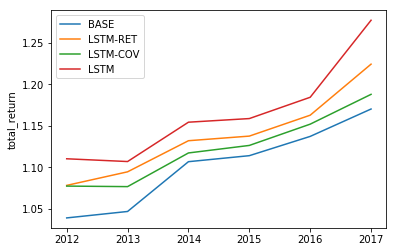

In [166]:
for model in model_names:
        sns.lineplot(x = advanced_results[model]['total_return'].index ,y = advanced_results[model]['total_return'], label = model)